<a href="https://colab.research.google.com/github/pjuvm/BCI-lab-1/blob/project1/BCI_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
from pylab import *
from collections import Counter
import matplotlib.pyplot as plt
!pip install mne
import mne
from mne.stats import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 16.5 MB/s eta 0:00:00


In [4]:
os.listdir()

['.config', 'drive', 'sample_data']

In [5]:
!git clone --branch project1 https://github.com/pjuvm/BCI-lab-1.git

Cloning into 'BCI-lab-1'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 80 (delta 22), reused 27 (delta 6), pack-reused 30
Receiving objects: 100% (80/80), 107.87 MiB | 27.91 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [6]:
os.chdir("BCI-lab-1")

In [7]:
from loadmat import *
from load_p300_data import *
from plot_p300_erps import *


#Parts C,D, and E

In [8]:
def subject_epoch_groups(subject):
  eeg_time, eeg_data, rowcol_id, is_target = load_training_eeg(subject = subject)
  event_sample, is_target_event = get_events(rowcol_id, is_target)
  eeg_epochs, erp_times = epoch_data(eeg_time, eeg_data, event_sample, epoch_start_time = -0.5, epoch_end_time = 1)
  target_epochs = eeg_epochs[is_target_event]
  nontarget_epochs = eeg_epochs[~is_target_event]
  return target_epochs.astype(float), nontarget_epochs.astype(float)

def erp_difference(EEG1,EEG2):
  """ this functions finds the absolute value of the difference between the ERPs of two EEG groups
  Args:
    EEG1: 3d array of (trials, time points, channels)
    EEG2: same as above
  Returns:
    Absolute value of difference between ERP (mean EEG) of two groups
  """
  target_ERP = EEG1[:,:,:].mean(0)
  nontarget_ERP = EEG2[:,:,:].mean(0)
  return np.abs(target_ERP - nontarget_ERP)

In [12]:
def p_value_gen(EEG1, EEG2, n_iter = 500, channel = 0, alpha = 0.05, random_seed=888):
  """ Function that generates a array of p-values of size (time points, channels)
  relating real data to bootstrapped data; viz probabilities of real data given the bootstrapped sample data
  Args:
    EEG1 -- array of shape (samples, time, channels)
    EEG2 -- as above
    n_iter -- number of bootstrap iterations
    channel -- int. The channel to generate p-values for
  Returns:
    p-values: array that has bootstrapped p-values for each slice. These are not corrected for multiple trials.
    significance list: an array that indexes where significant p-values occur during the epoch.
  """
  np.random.seed(random_seed)
  combined_epochs = np.vstack([EEG1,EEG2])
  real_erp_diff = erp_difference(EEG1,EEG2)  #the real ERP difference between two groups or conditions
  score = np.zeros(EEG1.shape[1],)                      #zero matrix to count significance
  for _ in range(n_iter):
    inds = np.random.randint(0,len(combined_epochs),len(combined_epochs))
    bootstrapped_epochs = combined_epochs[inds]
    bootstrap_target = bootstrapped_epochs[:EEG1.shape[0]] #use same number of trials eg 150 as data
    bootstrap_nontarget = bootstrapped_epochs[EEG2.shape[0]:] #use same number of trials eg 750 as data
    #bootstrapped nontarget ERP, mean of the 750 samples
    bootstrap_erp_diff_array = erp_difference(bootstrap_target,bootstrap_nontarget) #absolute difference of the two as statistic
    #print(bootstrap_erp_diff_array.shape)

    x = (bootstrap_erp_diff_array[:,channel] > real_erp_diff[:,channel]).astype(int) #whenever a bootstrap value is larger than the real data add 1
    score += x

  return score/n_iter, np.where(score/n_iter < alpha) #calculate percentage of bootstrap samples bigger than the real data

In [26]:
def find_significant_times(channel, subjects, samples_per_epoch=384, n_iter=500, random_seed=888):
  np.random.seed(random_seed)
  score = np.zeros(samples_per_epoch,)
  for subj in subjects:
    EEGa,EEGb = subject_epoch_groups(subj)  #split data into two conditions or groups of EEG
    my_raw_pvals = p_value_gen(EEG1 = EEGa, EEG2 = EEGb, n_iter = 500, channel = channel, alpha = 0.05)   #get the uncorrected p-values
    mask = fdr_correction(my_raw_pvals[0])[0]   #false discovery rate correction for the p-values
    mask = mask.astype(int)     #takes boolean mask converts to binary matrix of 1s and 0s
    score += mask               #adds the above matrix to the score matrix, to tally significant time points across subjects
  my_mask = np.where(score != 0)
  #erp_times = np.linspace(-0.5,1.0,384)

  return score

In [28]:
A = find_significant_times(channel = 6, subjects = [3,4,5,6,7,8,9,10], n_iter = 3000)

In [29]:
A

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 2., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

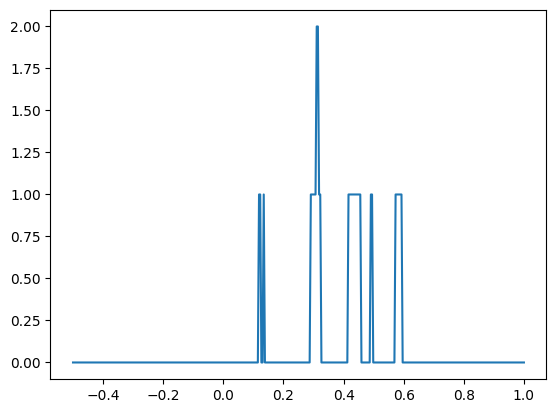

In [31]:
plt.plot(np.linspace(-0.5,1,384), A)

#Part F

In [53]:
subjects = [3,4,5]
subject_median_ERPs = []
for subj in subjects:
  eeg_time, eeg_data, rowcol_id, is_target = load_training_eeg(subject = subj)

  event_sample, is_target_event = get_events(rowcol_id, is_target)
  eeg_epochs, erp_times = epoch_data(eeg_time, eeg_data, event_sample, epoch_start_time = -0.5, epoch_end_time = 1)
  subj_median = np.median(eeg_epochs, 0)
  subject_median_ERPs.append(subj_median)

In [66]:
stacked_median_erps = np.stack(subject_median_ERPs)
print(stacked_median_erps.shape)
group_median_erp = np.median(stacked_median_erps, axis = 0)
print(group_median_erp.shape)

(3, 384, 8)
(384, 8)


In [105]:
#N2 -- 175-250ms after onset of stimulus
#P3b -- 300ms after onset of stimulus
"""
To address this possibility, the present study explores the value of incorporating information from electrode locations
that are not traditionally associated with the P300 response.
In addition, several data preprocessing and model parameters are evaluated to assess
the relative effects with respect to the new spatial information.
Using a SWLDA classifier, both offline and online results obtained from 64-channel data
show that some of the most discriminable EEG features evoked by the P300 speller occur
at posterior electrodes (namely PO7, PO8, Oz), and that these
features can significantly improve classification performance
when used in conjunction with the classical P300 feature space
(i.e., EEG features at electrodes Fz, Cz, Pz [20]).

"""

channel_names = ["Fz", "Cz","Pz","Oz","P3","P4","PO7","PO8"]

In [112]:
#If we use static times, e.g. time = 200 and time = 300

N2_voltage = group_median_erp[200,:]
P3b_voltage = group_median_erp[300,:]
N2_voltage.shape

(8,)

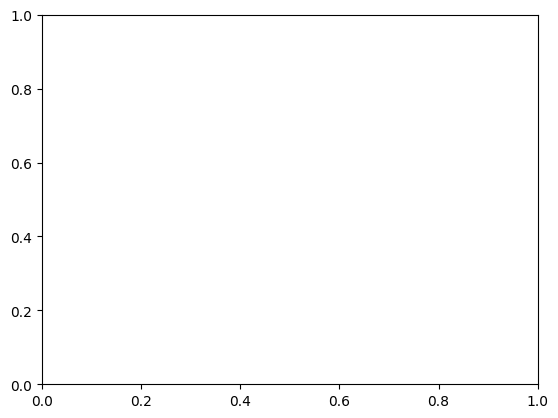

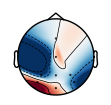

(<matplotlib.image.AxesImage at 0x79888b993070>,
 <matplotlib.colorbar.Colorbar at 0x79888b84e860>)

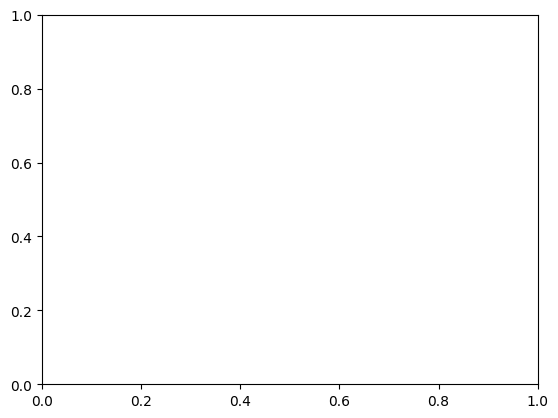

In [111]:
plot_topo.plot_topo(channel_names = channel_names, channel_data = P3b_voltage)